In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

# enter your exotic-ld path if it isn't already defined in your 
# environment variables. 
os.environ['EXO_LD_PATH'] = '/Users/tylergordon/research/exotic_ld_data'

from fit import fit_wlc, fit_spec
from plot_utils import get_wl_models 
from distributions import *

In [2]:
# define priors for the planet's parameters. Use the 
# priors defined in distributions.py
priors_dict = {
    'period': normal_prior(1.4015, 0.00018),
    'radius': normal_prior(0.0212, 0.001),
    't0': uniform_prior(0.05, 0.125, init=0.085),
    'semimajor_axis': normal_prior(7.61, 0.31),
    'inclination': normal_prior(85.8 * np.pi / 180, 0.8 * np.pi / 180),
    'eccentricity': uniform_prior(0.0, 0.21, init=0.01),
    'periastron': uniform_prior(0, np.pi, init=np.pi/2),
    'reference': 'https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..58A/abstract'
}

# stellar parameters for computing priors 
# on the limb-darkening coefficients
st_params_dict = {
    'mh': 0.04,
    'logg': 4.04,
    'teff': 3800,
    'reference': 'https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..58A/abstract'
}

# load all the data.
base_dir = '/Users/tylergordon/research/compass/targets/134.01/T1/reduction/stage3/'
time = np.load(base_dir + '134.01_T1_nrs1_times.npy')
time -= time[0]
spec = np.load(base_dir + '134.01_T1_nrs1.npy')
cube = np.load(base_dir + '134.01_T1_nrs1_cleaned_cube.npy')
wavs = np.load(base_dir + '134.01_T1_nrs1_wav.npy')
xshift = np.load(base_dir + '134.01_T1_nrs1_shiftx.npy')
yshift = np.load(base_dir + '134.01_T1_nrs1_shifty.npy')

xshift -= np.mean(xshift)
yshift -= np.mean(yshift)

In [3]:
# fit the white light curve. This returns a result 
# dictionary, which can be passed directly to the 
# spectral fitting function in the next step. 
# Most of the inputs here are self-explanatory, 
# except for cube, which is optional but if provided 
# should be the cleaned data cube of shape 
# (N_times x N_y-pixels x N_wavelengths). 
# gp=True means use a gp model, default is False. 
# n_pca_components is the number of PCA vectors to 
# use for detrending. PCA detrending is only carried 
# out if a data cube is provided. If you don't want to 
# include PCA detrending set cube=None or n_pca_components=0. 
# You can also detrend on another set of vectors such as the 
# x and y-shifts. I commented this out because it doesn't 
# seem to do anything for this particular target, but 
# feel free to experiment. 

result = fit_wlc(
    time, 
    spec, 
    wavs,
    priors_dict,
    st_params_dict,
    'nrs1', 
    samples=30000, 
    burnin=20000, 
    nproc=2, 
    gp=False,
    cube=cube,
    #detrending_vectors=np.array([xshift, yshift]).T,
    n_pca_components=3,
    save_chains=False,
    return_chains=True
)

100%|██████████████████████████████████████████████████████████████████| 30000/30000 [06:51<00:00, 72.98it/s]


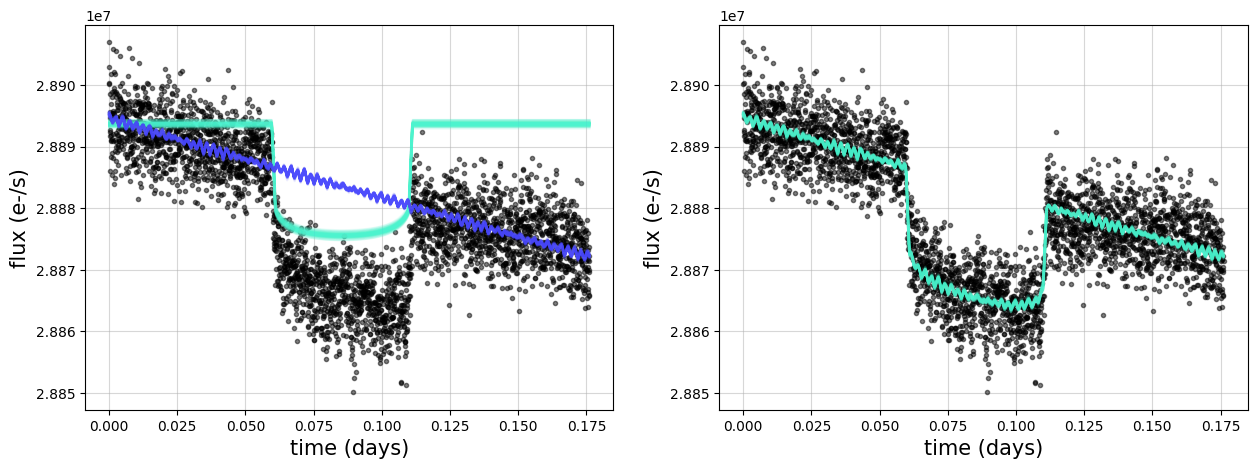

In [4]:
# Plot the results from fitting the white light curve. The first plot 
# separates the components of the fit into the gp (if gp=True above), 
# transit model, and systematics model. The second plot shows the sum of 
# all the components. 

if result['gp']:
    trans, sys, pred, f = get_wl_models(result, nsamples=100)
else:
    trans, sys, f = get_wl_models(result, nsamples=100)

color_inds = (0.4, 0.1, 0.9)
colors = [plt.cm.rainbow(i) for i in color_inds]

flux = np.sum(spec, axis=1)[~result['mask']]
masked_time = time[~result['mask']]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(masked_time, flux, '.', color='k', alpha=0.5)
axs[0].plot(masked_time, trans.T, color=colors[0], alpha=0.1);
axs[0].plot(masked_time, sys.T + f, color=colors[1], alpha=0.1);

if result['gp']:
    axs[0].plot(masked_time, pred.T + f, color=colors[2], alpha=0.1);

axs[1].plot(masked_time, flux, '.', color='k', alpha=0.5)

if result['gp']:
    axs[1].plot(masked_time, trans.T + sys.T + pred.T, color=colors[0], alpha=0.1);
else:
    axs[1].plot(masked_time, trans.T + sys.T, color=colors[0], alpha=0.1);

[ax.grid(alpha=0.5) for ax in axs];
[ax.set_xlabel('time (days)', fontsize=15) for ax in axs];
[ax.set_ylabel('flux (e-/s)', fontsize=15) for ax in axs];

In [5]:
# fit the spectral light curves. The options 
# here are also pretty self-explanatory, except 
# for n_pca_components_spec, which allows you 
# to specify how many wavelength-dependent 
# PCA vectors you want to use in the fitting. 
# this is similar to n_pca_components above, 
# except the PCA is done on the pixels at and 
# near the wavelength bin rather than from 
# the whole data cube. If n_pca_components is 
# not specified, then the PCA vectors 
# from the white light curve fitting are 
# also used for detrending. If you don't want 
# to use those vectors, then set n_pca_components 
# to zero here. As above, you can also include additional 
# vectors for detrending by passing an argument for 
# detrending_vectors. 

chains, bin_wavs = fit_spec(
    result,
    wav_per_bin=0.02, 
    samples=10000, 
    burnin=5000, 
    nproc=12, 
    n_pca_components_spec=2,
    #detrending_vectors=np.array([xshift, yshift]).T,
    save_chains=False,
    return_chains=True
)

running bands 37-42 of 42                                   

Text(0.5, 0, 'wavelength (microns)')

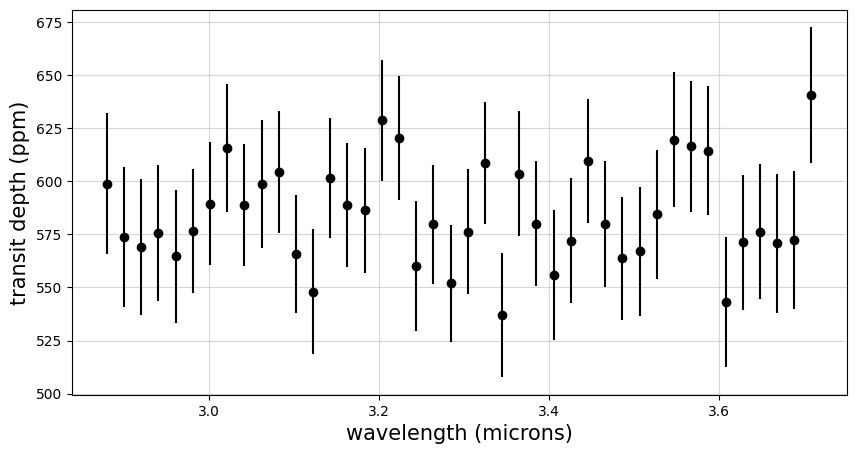

In [10]:
# plot the spectrum! 

rp = np.array([np.mean(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chains])
err = np.array([np.std(chain.get_chain()[:, :, 0], axis=(0, 1)) for chain in chains])

dep = rp**2 * 1e6
dep_err = 2 * rp * err * 1e6

plt.figure(figsize=(10, 5))
plt.plot(bin_wavs, dep, 'ko')
plt.errorbar(bin_wavs, dep, yerr=dep_err, color='k', ls='none')
plt.grid(alpha=0.5)
plt.ylabel('transit depth (ppm)', fontsize=15)
plt.xlabel('wavelength (microns)', fontsize=15)